In [1]:
# CMSE Project
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import random as random
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.formula.api as smf
import seaborn as sns

Here I load in the data and spit out some summary statistics.

In [2]:
# Reading in Data
# Keys to extract formatted State and County names
key = pd.read_excel('fips_codes_website.xls')   # Counties and major cities
key00 = pd.read_csv('FIPS_countycodes.txt',delimiter=',')  # Counties only
key00['GU Name'] = key00['GU Name'].str[:-7]  # Slice 'county' from names
# Housing Data
zillow2019 = pd.read_excel("County_Zhvi_Summary_AllHomes2019.xls")
zillow2019['RegionName'] = zillow2019['RegionName'].str[:-7]  # Slice 'county' from names
# Crime
crime2010 = pd.read_csv('33523-0001-crimedata2010.txt',delimiter='\t')
crime2012 = pd.read_csv('35019-0001-crimedata2012.txt',delimiter='\t')
crime2014 = pd.read_csv('36399-0001-crimedata2014.txt',delimiter='\t')
crime2016 = pd.read_csv('37059-0001-crimedata2016.txt',delimiter='\t')
# Enumployment & Wages
#test_wages_18 = pd.read_excel('allhlcn183.xlsx',sheet_name='US_St_Cn_MSA')
wage_unemp2018 = pd.read_csv('allhlcn183wage_unemp2018.txt',delimiter='\t',dtype={'St':str})
wage_unemp2016 = pd.read_csv('allhlcn163wage_unemp2016.txt',delimiter='\t',dtype={'St':str})
wage_unemp2014 = pd.read_csv('allhlcn143wage_unemp2014.txt',delimiter='\t',dtype={'St':str})
wage_unemp2012 = pd.read_csv('allhlcn123wage_unemp2012.txt',delimiter='\t',dtype={'St':str})
wage_unemp2010 = pd.read_csv('allhlcn103wage_unemp2010.txt',delimiter='\t',dtype={'St':str})

print("2014 crime:",crime2014.shape,"// key:",key.shape)
print("2019 Housing:",zillow2019.shape)
print('2018 Wages:',wage_unemp2018.shape)
x = ((crime2014.shape[0])*(crime2014.shape[1]))*4 + ((wage_unemp2018.shape[0])*(wage_unemp2018.shape[1]))*5 + (key00.shape[0])*key00.shape[1]
print(x,'unique datapoints in all datasets')

2014 crime: (3177, 56) // key: (41787, 7)
2019 Housing: (1921, 17)
2018 Wages: (62724, 21)
7313843 unique datapoints in all datasets


In [21]:
wage_unemp2010.tail()

,Area Code,St,Cnty,Own,NAICS,Year,Qtr,Area Type,St Name,Area,...,Industry,Status Code,Establishment Count,July Employment,August Employment,September Employment,Total Quarterly Wages,Average Weekly Wage,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
62353,C4974,NaN,NaN,5,1024,2010,3,MSA,NaN,"Yuma, AZ MSA",...,Professional and business services,NaN,389,"5,372","5,458","5,618","52,968,527",743,0.79,0.75
62354,C4974,NaN,NaN,5,1025,2010,3,MSA,NaN,"Yuma, AZ MSA",...,Education and health services,NaN,344,"6,294","6,463","6,468","63,844,487",766,0.82,1.07
62355,C4974,NaN,NaN,5,1026,2010,3,MSA,NaN,"Yuma, AZ MSA",...,Leisure and hospitality,NaN,319,"4,913","4,882","4,935","18,336,919",287,0.88,0.96
62356,C4974,NaN,NaN,5,1027,2010,3,MSA,NaN,"Yuma, AZ MSA",...,Other services,NaN,279,"1,122","1,106","1,102","6,727,744",466,0.60,0.71
62357,C4974,NaN,NaN,5,1029,2010,3,MSA,NaN,"Yuma, AZ MSA",...,Unclassified,NaN,11,1,1,1,"9,000",692,0.02,0.02


Here is where I do the bulk of my data cleaning. 

I found it difficult to eliminate the copyset errors because the wage_unemployment dataframes are coded with key values in the County and State columns (as seen above). There is national, state, and metropolitan area data in these dataframes. But the values that I would need to concat/merge on are 'NaN' for these other regional divisions. So I am not able to merge with the dataframe as is, and dropping the problem rows then merging produces the error. 

The rest of my data cleaning is just converting columns of numbers from strings into integers. The BLS also started a new method of how they code in the various industries within a region, so I also have to clean that up to match past years. 

In [3]:
def crime_cleaner(data):
    # Merge key with crime db to gain state / city names
    washing = data.merge(key00,left_on=['FIPS_CTY','FIPS_ST'], right_on=['County FIPS Code','State FIPS Code'])
    # Rearrange columns
    washing = washing[['STUDYNO','EDITION','PART','IDNO','FIPS_ST','State FIPS Code','State Abbreviation','FIPS_CTY','County FIPS Code','GU Name','CPOPARST','AG_ARRST','JURFLAG','COVIND', 'GRNDTOT','P1TOT','P1VLNT','P1PRPTY','MURDER','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY']]
    
    # Select only wanted columns
    clean = washing[['State Abbreviation','GU Name','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY']]
    return clean
def wage_cleaner(data):
        # Drop Unwanted columns
    base = data.drop(['Area\nCode','Own','NAICS','Qtr','Status Code'],axis=1)
    # Select County level data
    washing = base.loc[(base['Area Type'] == 'County')]
    washing['Cnty'] = washing['Cnty'].astype('int64') # Convert to int for merging // Throws error
    washing['St'] = washing['St'].astype('int64')    # Convert to into for merging // Throws error
    # Merge with key
    washing = washing.merge(key00,left_on=['St','Cnty'], right_on=['State FIPS Code','County FIPS Code'])
    # Rearrange columns and drop unwanted columns
    county_wages = washing[['State Abbreviation','GU Name', 'Year', 'Area Type', 'St Name', 'Area', 'Ownership','Industry', 'Establishment Count', 'July Employment','August Employment', 'September Employment', 'Total Quarterly Wages','Average Weekly Wage', 'Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.']]
    county_wages['Establishment Count'] = county_wages['Establishment Count'].str.replace(',','')  # Get rid of comma // Throws Error
    county_wages['Establishment Count'] = pd.to_numeric(county_wages['Establishment Count'])   # Convert to interger // Throws Error
    county_wages['September Employment'] = county_wages['September Employment'].str.replace(',','')  # Get rid of comma // Throws Error
    county_wages['September Employment'] = pd.to_numeric(county_wages['September Employment'])    # Convert to interger // Throws Error  
    county_wages['Average Weekly Wage'] = county_wages['Average Weekly Wage'].str.replace(',','')  # Get rid of comma // Throws Error
    county_wages['Average Weekly Wage'] = pd.to_numeric(county_wages['Average Weekly Wage'])  # Convert to interger // Throws Error
    county_wages['Industry'] = county_wages['Industry'].str.replace('0','') # Formatting to fix year 2018 industry codes
    county_wages['Industry'] = county_wages['Industry'].str.replace('1','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('2','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('3','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('4','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('5','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('6','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('7','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('8','')
    county_wages['Industry'] = county_wages['Industry'].str.replace('9','')
    
#     state_wages = base.loc[(base['Area Type'] == 'State')]   # State Level Wages
#     nation_wages = base.loc[(base['Area Type'] == 'Nation')]    # Nation Level Data
#     urban_wages = base.loc[(base['Area Type'] == 'MSA')]   # Metropolitan Level Data
    return county_wages #,state_wages,nation_wages,urban_wages

def search(county,state):
    db10 = db2010.loc[(db2010['State Abbreviation'] == state) & (db2010['GU Name'] == county)]
    db12 = db2012.loc[(db2012['State Abbreviation'] == state) & (db2012['GU Name'] == county)]
    db14 = db2014.loc[(db2014['State Abbreviation'] == state) & (db2014['GU Name'] == county)]
    db16 = db2016.loc[(db2016['State Abbreviation'] == state) & (db2016['GU Name'] == county)]
    db18 = economic18.loc[(economic18['State Abbreviation'] == state) & (economic18['GU Name'] == county)]
    return db10,db12,db14,db16

# Yearly cleaned databases
crime10 = crime_cleaner(crime2010)
crime12 = crime_cleaner(crime2012)
crime14 = crime_cleaner(crime2014)
crime16 = crime_cleaner(crime2016)
cols = list(crime14.columns.values) # Grab columns
# Cleaned Wage Data
economic10 = wage_cleaner(wage_unemp2010) # Returns 3 items; county, state, national, and urban level data sets
economic12 = wage_cleaner(wage_unemp2012)
economic14 = wage_cleaner(wage_unemp2014)
economic16 = wage_cleaner(wage_unemp2016)
economic18 = wage_cleaner(wage_unemp2018)
#wage18[0]['Industry'] = [i[i.find(' ')+1:] for i in wage18[0]['Industry']] # Get to work
economic18['Industry'] = economic18['Industry'].str[1:] # Remove first space in 2018 industry codes

# Combined crime and economic dataframes and rearrange columns
db2010 = crime10.merge(economic10,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2010 = db2010[['Year','State Abbreviation','GU Name','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY','Area Type','St Name','Area','Ownership','Industry','Establishment Count','July Employment','August Employment','September Employment','Total Quarterly Wages','Average Weekly Wage','Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.']]
db2012 = crime12.merge(economic12,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2012 = db2012[['Year','State Abbreviation','GU Name','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY','Area Type','St Name','Area','Ownership','Industry','Establishment Count','July Employment','August Employment','September Employment','Total Quarterly Wages','Average Weekly Wage','Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.']]
db2014 = crime14.merge(economic14,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2014 = db2014[['Year','State Abbreviation','GU Name','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY','Area Type','St Name','Area','Ownership','Industry','Establishment Count','July Employment','August Employment','September Employment','Total Quarterly Wages','Average Weekly Wage','Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.']]
db2016 = crime16.merge(economic16,left_on=['State Abbreviation','GU Name'],right_on=['State Abbreviation','GU Name'])
db2016 = db2016[['Year','State Abbreviation','GU Name','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY','Area Type','St Name','Area','Ownership','Industry','Establishment Count','July Employment','August Employment','September Employment','Total Quarterly Wages','Average Weekly Wage','Employment Location Quotient Relative to U.S.','Total Wage Location Quotient Relative to U.S.']]

C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Here is some code to randomly pull some counties from my database. There is no data attached to them, useful to find random unknown counties to search/test against.

In [4]:
# Generate Sample of Randomly Selected Counties
n = 5 # Numer of random samples
print("Randomly Generated Cities:\nState County")
for i in range(n):
    r = random.randint(0,len(crime12))
    print(crime12['State Abbreviation'].iloc[r]+', '+crime12['GU Name'].iloc[r])

Randomly Generated Cities:
State County
VA, Culpeper
IA, Page
MT, Deer Lodge
GA, Bartow
KY, Letcher


Here is a search function that will find all available data for any single county. This cell needs to be run for all other cells to work.

In [5]:
# S E A R C H #
##############
print("IF USING 'KEY00', COUNTIES ONLY")
CountCit = input("Enter a county: ")
state = input("Enter a state abbreviation: ")

collect = search(CountCit,state)

IF USING 'KEY00', COUNTIES ONLY
Enter a county: Orange
Enter a state abbreviation: CA


**Random Database of Counties Generation**

Here is where I actualy generate a database of random counties and all associated information. The cells immediatly following will automatically plot and display info on whatever single county you searched for. While not specifically useful for analysis I encourage you to browse through them simply to see what variables I have in my data. Otherwise this part can be skipped to where I have a bolded headling about regressions.

Each time this cell is ran an entirely new database is generated.

In [6]:
# Selects 10 Random counties and stores them as a dictionary by count // Key = MI, County
samp_db = {}
for n in range(10):
    r = random.randint(0,len(crime12))
    x = crime12['State Abbreviation'].iloc[r] # Pull State Abreviation
    y = crime12['GU Name'].iloc[r]  # Pull analogous county name
    z = x+', '+y # Format name for dictionary key
    agg = search(y,x) # Return criminal and economic data
    samp_db[z] = agg  # Add data to empty dictionary
print(samp_db.keys())

dict_keys(['SD, Charles Mix', 'SD, Hand', 'LA, Tangipahoa', 'VA, Appomattox', 'VA, Fairf', 'WY, Niobrara', 'MO, Pemiscot', 'NC, Martin', 'KY, Carlisle', 'NC, Union'])


In [22]:
# Arrest Options
collect[0].columns[:48]

Index(['Year', 'State Abbreviation', 'GU Name', 'MURDER', 'P1TOT', 'P1VLNT',
       'P1PRPTY', 'RAPE', 'ROBBERY', 'AGASSLT', 'BURGLRY', 'LARCENY',
       'MVTHEFT', 'ARSON', 'OTHASLT', 'FRGYCNT', 'FRAUD', 'EMBEZL', 'STLNPRP',
       'VANDLSM', 'WEAPONS', 'COMVICE', 'SEXOFF', 'DRUGTOT', 'DRGSALE',
       'COCSALE', 'MJSALE', 'SYNSALE', 'OTHSALE', 'DRGPOSS', 'COCPOSS',
       'MJPOSS', 'SYNPOSS', 'OTHPOSS', 'GAMBLE', 'BOOKMKG', 'NUMBERS',
       'OTGAMBL', 'OFAGFAM', 'DUI', 'LIQUOR', 'DRUNK', 'DISORDR', 'VAGRANT',
       'ALLOTHR', 'SUSPICN', 'CURFEW', 'RUNAWAY'],
      dtype='object')

Here is a function to clean the crime data and store it into a 'crime dictionary'. Will work if you update the 'crimes' variable at the top with new crimes to pull.

Average house price, 2019:  $ 723300
Metro areas: Los Angeles-Long Beach-Anaheim
{'DRGPOSS': (18439, 13500, 15344, 20667), 'AGASSLT': (4557, 4307, 4216, 4764), 'DUI': (15955, 14633, 12615, 10826)}


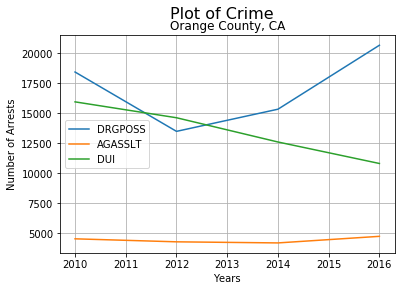

In [8]:
# Test Plotting & Collecting Specific Data
crimes = 'DRGPOSS','AGASSLT','DUI'
def searchcrime_cleaner(data,crimes,tsearch):
    container = []
    count = 0
    for i in range(len(data)):
        knight = data[count][tsearch].values
        container.append(knight)
        count += 1
    container = container[0][0],container[1][0],container[2][0],container[3][0]
    return container
# Pull cleaned crime data, store in dictionary
crime_dic = {}
for i in crimes:
    tsearch = i
    crime_dic[i] = searchcrime_cleaner(collect[:4],crimes,tsearch)

name = collect[0]['GU Name'].values, collect[0]['State Abbreviation'].values
name = name[0]+" County, "+name[1]
years = (2010,2012,2014,2016)
#Plotting
for i in crime_dic:
    plt.plot(years,crime_dic[i],label=i)
    plt.suptitle("Plot of Crime",size=16)
    plt.title(name[0], size=12)
    plt.xlabel("Years")
    plt.ylabel("Number of Arrests")
    plt.grid()
    plt.legend()
plt.savefig('presi_crimes')
houdata = zillow2019.loc[(zillow2019['RegionName'].values == CountCit) & (zillow2019['State'].values == state)]
try:
    print("Average house price, 2019:  $",int(houdata['Zhvi']))
    print("Metro areas:",houdata['Metro'].values[0])
except:
    print('--No Housing Data Available For This County--')
print(crime_dic)

In [9]:
# Graphics for Industry and economic Data
collect[0].columns[48:]    # Statistic options

Index(['Area Type', 'St Name', 'Area', 'Ownership', 'Industry',
       'Establishment Count', 'July Employment', 'August Employment',
       'September Employment', 'Total Quarterly Wages', 'Average Weekly Wage',
       'Employment Location Quotient Relative to U.S.',
       'Total Wage Location Quotient Relative to U.S.'],
      dtype='object')

Here I wrote a function to clean and store the industry data into a dictionary as well as a function to pull the 4 largest industries in our county. Although this is only ran with the individual county data (as opposed to finding the largest industries across the sample database, it shouldn't matter much since the most popular industries do not vary much from county to county).

In [10]:
# Function for cleaning data from search variable
def search_industrydata_cleaner(data,stat,tsearch):
    container = []
    count = 0
    for n in range(len(data)):    # Loop for pulling data of multiple years      
        container.append(data[n].loc[(data[n]['Industry']==tsearch)][stat].values[0])
#                          dictionary//year       dictionary//year//column    comparison/DATA TO PULL
        count += 1
    #container = container[0][0],container[1][0],container[2][0],container[3][0],container[4][0]
    return container # Return a list of individual values

# Function to find largest industries per county
def most_establishments(data):
    data = data.loc[(data['Industry'] != '10 Total, all industries')] # Remove Totals, 2018
    data = data.loc[(data['Industry'] != 'Total, all industries')] # Remove Totals, all other years
    data = data.nlargest(4,'Establishment Count')
    return data

industry = most_establishments(collect[3])  # Returns 4 largest industries in 2016 ,index = 3
industrydata = industry # Data set for other metrics in largest industries
industry = list(industry['Industry']) # List of largest industries for reference purposes

{'Service-providing': [88430, 89012, 93859, 101601],
 'Education and health services': [10335, 10599, 27158, 30003],
 'Professional and business services': [18734, 18651, 20355, 20181],
 'Trade, transportation, and utilities': [16318, 16019, 16617, 16677]}

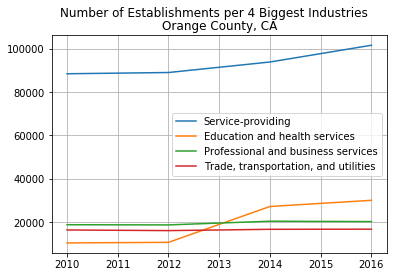

In [11]:
stat = 'Establishment Count'  
# Statistic associated with industry:: Establishment Count,Average Weekly Wage,September Employment
indus_dic = {}
for i in industry:
    tsearch = i
    rook = search_industrydata_cleaner(collect,stat,tsearch)
    indus_dic[i] = list(rook)
# Plotting Searched Data
name = collect[0]['GU Name'].values,collect[0]['State Abbreviation'].values
name = name[0][0]+" County, "+name[1][0]
years = 2010,2012,2014,2016

for i in indus_dic:
    plt.plot(years,indus_dic[i],label=i)
    plt.suptitle('Number of Establishments per 4 Biggest Industries')
    plt.title(name)
    plt.legend()
plt.grid()
plt.savefig('name')
indus_dic

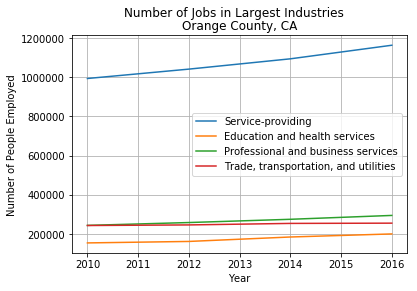

In [12]:
# Call Employment numbers
stat = 'September Employment'  
# Statistic associated with industry:: Establishment Count,Average Weekly Wage,September Employment
emp_dic = {}
for i in industry:
    tsearch = i
    rook = search_industrydata_cleaner(collect,stat,tsearch)
    emp_dic[i] = rook
# Plot
for i in industry:
    plt.plot(years,emp_dic[i],label=i)
    plt.suptitle('Number of Jobs in Largest Industries')
    plt.ylabel('Number of People Employed')
    plt.xlabel('Year')
    plt.title(name)
    plt.legend()
plt.grid()
plt.savefig('Industries with most employed')

{'Service-providing': [917, 963, 979, 1090], 'Education and health services': [938, 933, 883, 975], 'Professional and business services': [1091, 1131, 1207, 1364], 'Trade, transportation, and utilities': [905, 940, 940, 1023]}


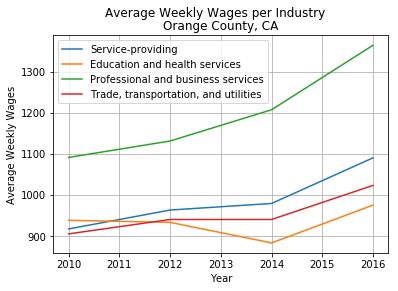

In [24]:
# Call Wage Numbers
stat = 'Average Weekly Wage'  
# Statistic associated with industry:: Establishment Count,Average Weekly Wage,September Employment
wage_dic = {}
for i in industry:
    tsearch = i
    rook = search_industrydata_cleaner(collect,stat,tsearch)
    wage_dic[i] = rook
# Plot
for i in industry:
    plt.plot(years,wage_dic[i],label=i)
    plt.suptitle('Average Weekly Wages per Industry')
    plt.ylabel('Average Weekly Wages')
    plt.xlabel('Year')
    plt.title(name)
    plt.legend()
plt.grid()
print(wage_dic)

**REGRESSIONS**

Here I figured out how to [sort of] do multiple regression for a single county. It runs, however the numbers are junk, as indicated by the near perfect R-squared.

Here I wrote a couple functions specifically designed to clean and format data for multiple counties to be easily stored inside a dataframe.

In [23]:
# Function for cleaning data sample database
def industrydata_cleaner(data,stat,tsearch):
    container = []
    for i in data:
        for n in range(len(data[i])):
            x = data[i][n].loc[data[i][n]['Industry'] == tsearch]
            x = x[stat].values #[0]
            x = x.tolist()
            container.append(x)
    return container # Return a list of individual values

def sample_crime_cleaner(data,crime):
    container = []
    for i in data:
        for n in range(len(data[i])):
            y = data[i][n][crime]
            y = y.values[0]
            container.append(y)
    return container

samp_dic = {}
stat = 'Establishment Count','Average Weekly Wage','September Employment'
for s in stat:
    for n in industry:
        samp_dic[n+' '+s] = industrydata_cleaner(samp_db,s,n)
        
crimes = collect[0].columns[:48] # Reset crimes to grab all crime data
for i in crimes:
    samp_dic[i] = sample_crime_cleaner(samp_db,i)
finaldb = pd.DataFrame(data=samp_dic)
# Reorganize columns
finaldb = finaldb[[ 'Year','State Abbreviation','GU Name','Service-providing Establishment Count','Education and health services Establishment Count','Professional and business services Establishment Count','Trade, transportation, and utilities Establishment Count','Service-providing Average Weekly Wage','Education and health services Average Weekly Wage','Professional and business services Average Weekly Wage','Trade, transportation, and utilities Average Weekly Wage','Service-providing September Employment','Education and health services September Employment','Professional and business services September Employment','Trade, transportation, and utilities September Employment','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY']]
print("Counties in Sample Data: ",samp_db.keys(),'\n')
print("Columns in final database: ",finaldb.columns)
print('\nFinal Database for all 10 counties over 4 years in my sample.')
finaldb

Counties in Sample Data:  dict_keys(['SD, Charles Mix', 'SD, Hand', 'LA, Tangipahoa', 'VA, Appomattox', 'VA, Fairf', 'WY, Niobrara', 'MO, Pemiscot', 'NC, Martin', 'KY, Carlisle', 'NC, Union']) 

Columns in final database:  Index(['Year', 'State Abbreviation', 'GU Name',
       'Service-providing Establishment Count',
       'Education and health services Establishment Count',
       'Professional and business services Establishment Count',
       'Trade, transportation, and utilities Establishment Count',
       'Service-providing Average Weekly Wage',
       'Education and health services Average Weekly Wage',
       'Professional and business services Average Weekly Wage',
       'Trade, transportation, and utilities Average Weekly Wage',
       'Service-providing September Employment',
       'Education and health services September Employment',
       'Professional and business services September Employment',
       'Trade, transportation, and utilities September Employment', 'MURD

,Year,State Abbreviation,GU Name,Service-providing Establishment Count,Education and health services Establishment Count,Professional and business services Establishment Count,"Trade, transportation, and utilities Establishment Count",Service-providing Average Weekly Wage,Education and health services Average Weekly Wage,Professional and business services Average Weekly Wage,...,OFAGFAM,DUI,LIQUOR,DRUNK,DISORDR,VAGRANT,ALLOTHR,SUSPICN,CURFEW,RUNAWAY
0,2010,SD,Charles Mix,[222],[26],[22],[87],[462],[522],[550],...,0,63,112,0,50,0,126,0,3,9
1,2012,SD,Charles Mix,[217],[25],[21],[84],[484],[608],[599],...,1,84,168,0,38,1,146,0,1,3
2,2014,SD,Charles Mix,[217],[29],[23],[80],[510],[631],[689],...,1,104,72,0,46,0,43,0,1,0
3,2016,SD,Charles Mix,[216],[29],[26],[77],[545],[658],[716],...,4,128,59,15,45,0,70,0,1,1
4,2010,SD,Hand,[94],[10],[13],[34],[485],[511],[604],...,0,8,12,0,0,0,9,0,0,0
5,2012,SD,Hand,[91],[11],[12],[32],[511],[508],[622],...,0,6,2,0,0,0,1,0,0,0
6,2014,SD,Hand,[96],[11],[12],[33],[560],[540],[639],...,0,10,5,0,1,0,4,0,0,0
7,2016,SD,Hand,[93],[11],[11],[32],[616],[613],[754],...,0,8,1,0,1,0,13,0,0,0
8,2010,LA,Tangipahoa,[2209],[320],[344],[717],[632],[512],[557],...,177,757,167,114,719,36,5071,8,51,2
9,2012,LA,Tangipahoa,[2176],[328],[353],[700],[577],[502],[591],...,2,105,119,102,481,20,2362,2,0,1


Here is a regression of the number of establishments in each of the largest industries on drug possession arrests.

In [ ]:
x = finaldb[list(finaldb.columns.values[3:7])]  # Use only the first 3 columns to regress
y = finaldb['DRGPOSS']  # Set y variable

model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

I made a visualization of the part of the dataframe I ran a regression on.

In [ ]:
plt.scatter(finaldb['Service-providing Estab. Count'],y,color='b',label='Service-providing Estab. Count',alpha=0.5)
plt.scatter(finaldb['Trade, transportation, and utilities Estab. Count'],y,color='y',alpha=0.5,label='Trade, transportation, and utilities Estab. Count')
plt.scatter(finaldb['Professional and business services Estab. Count'],y,color='r',alpha=0.5,label='Professional and business services Estab. Count')
plt.scatter(finaldb['Education and health services Estab. Count'],y,color='g',alpha=0.5,label='Education and health services Estab. Count')

plt.ylabel('Number of DRGPOSS arrests')
plt.xlabel('Number of Establishments')
plt.title('Number of Establishments per Industry over \n Number of Drug Possession Arrests')
plt.legend(loc='best')
plt.grid()
#plt.savefig('Finalreg')

You can see some pretty serious outliers on my graph. So I'll try to control for population. 

The cell immedietly below this text will pull the largest cities based on total property crimes greater than 15,000. As it turns out this is a poor control for population and we still get some significant outliers so I end up dropping those to. We are left with 11 major counties; 4 in CA, 4 in NY, 2 in TX, Philadelphia, Las Vegas, and Maricopa AZ.

In [ ]:
#Create a dataframe of counties with PITOTs of greater than 10,000
masked_Lc10 = db2010.mask(db2010['P1TOT'] < 15000)
masked_Lc10 = masked_Lc10.dropna(axis = 0, how='any')
masked_Lc10 = masked_Lc10.reset_index()  # resets the index to easily pull random counties by index
#print(masked_Lc10['DRGPOSS']) # Used to see what outliers to drop
masked_Lc10 = masked_Lc10.drop(masked_Lc10.index[[1,5,12,14]]) # Drop outliers by index number

Largest_list = list(masked_Lc10['GU Name']+', '+masked_Lc10['State Abbreviation'])
Largest_counties = list(masked_Lc10['GU Name'])
Largest_states = list(masked_Lc10['State Abbreviation'])

control_db = {}
count = 0
for i in Largest_states:
    control_db[Largest_list[count]] = search(Largest_counties[count],i)
    count += 1

control_db.keys() # Returns 15 largest counties by P1TOT approximation

**If you want to analyze the largest cities, skip this cell.**

Here is the cell for smallest/medium sized counties. You can see where I set the upper and lower bounds of P1TOTs (total property crimes as a rough control for population) I want to pull. The loop folllowing will randomly pull 50 counties from the dataframe in preperation for analysis.

In [ ]:
# Create a dataframe for counties with 1,000 - 5,000 P1TOTs to control for population
masked_Sc10 = db2010.mask(db2010['P1TOT'] > 6000) # Mask counties with greater than 5000 P1TOTs
masked_Sc10 = masked_Sc10.mask(masked_Sc10['P1TOT'] < 4500)
masked_Sc10 = masked_Sc10.dropna(axis = 0, how='any')
masked_Sc10 = masked_Sc10.reset_index()  # resets the index to easily pull random counties by index

control_db = {}
count = 0
# Will pull x counties, same as largest counties returns
for n in range(50):
    r = random.randint(0,len(masked_Sc10)-1)
    x = masked_Sc10['State Abbreviation'].iloc[r] # Pull State Abreviation
    y = masked_Sc10['GU Name'].iloc[r]  # Pull analogous county name
    z = x+', '+y # Format name for dictionary key
    bop = search(y,x) # Return criminal and economic data
    control_db[z] = bop  # Add data to empty dictionary

print('Counties in the sample:',control_db.keys())

This cell will clean whatever population controlled sample you chose and store it into a neatly formatted dataframe.

In [ ]:
pop_dic = {}
stat = 'Establishment Count'
for n in industry:
    pop_dic[n+' Estab. Count'] = industrydata_cleaner(control_db,stat,n)
stat = 'Average Weekly Wage'
for n in industry:
    pop_dic[n+' Avg. Wkly Wage'] = industrydata_cleaner(control_db,stat,n)
stat = 'September Employment'
for n in industry:
    pop_dic[n+' Emplymnt'] = industrydata_cleaner(control_db,stat,n)
for i in crimes:
    pop_dic[i] = sample_crime_cleaner(control_db,i)
popdb = pd.DataFrame(data=pop_dic)
popdb = popdb[[ 'Year','State Abbreviation','GU Name','Service-providing Establishment Count','Education and health services Establishment Count','Professional and business services Establishment Count','Trade, transportation, and utilities Establishment Count','Service-providing Average Weekly Wage','Education and health services Average Weekly Wage','Professional and business services Average Weekly Wage','Trade, transportation, and utilities Average Weekly Wage','Service-providing September Employment','Education and health services September Employment','Professional and business services September Employment','Trade, transportation, and utilities September Employment','MURDER','P1TOT','P1VLNT','P1PRPTY','RAPE','ROBBERY','AGASSLT','BURGLRY','LARCENY','MVTHEFT','ARSON','OTHASLT','FRGYCNT','FRAUD','EMBEZL','STLNPRP','VANDLSM','WEAPONS','COMVICE','SEXOFF','DRUGTOT','DRGSALE','COCSALE','MJSALE','SYNSALE','OTHSALE','DRGPOSS','COCPOSS','MJPOSS','SYNPOSS','OTHPOSS','GAMBLE','BOOKMKG','NUMBERS','OTGAMBL','OFAGFAM','DUI','LIQUOR','DRUNK','DISORDR','VAGRANT','ALLOTHR','SUSPICN','CURFEW','RUNAWAY']]

In [ ]:
popdb

The variation among small and medium sized counties is very large. I have gotten some seemingly great looking regressions with statistically significant P-values and realistic R-squared -- and I have gotten some near perfect R-squareds with very insignificant P-values.

I have also made it very easy to switch between which variables to regress on. You will notice the first 3 columns of my dataframe are the year, state, and county so we can leave those out. columns 4-15 are the number of establishments, average weekly wages, and number of people employed in the 4 largest industries. The remaining rows are all crime variables. 

Running the regression on all economic variables doesn't turn out much better than just regressing on 'number of establishments'.

In [ ]:
x = popdb[list(popdb.columns.values[4:15])]  # Use only the first 3 columns to regress
y = popdb['DRGPOSS']  # Set y variable

model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

Here I am simply making some plots to show the wage and establishment data in the sample plotted against whatever crime you regressed against (changing the crime will make the graph labels inaccurate but the data will still plot)

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=False,sharex=False) # The graphs could share a y axis but I feel it is more readable with the numbers plotted on both axis
fig.set_figheight(7)
fig.set_figwidth(10)
ax1.scatter(popdb['Service-providing Estab. Count'],y,color='b',label='Service-providing Estab. Count',alpha=0.5)
ax1.scatter(popdb['Trade, transportation, and utilities Estab. Count'],y,color='y',alpha=0.5,label='Trade, transportation, and utilities Estab. Count')
ax1.scatter(popdb['Professional and business services Estab. Count'],y,color='r',alpha=0.5,label='Professional and business services Estab. Count')
ax1.scatter(popdb['Education and health services Estab. Count'],y,color='g',alpha=0.5,label='Education and health services Wages')

ax2.scatter(popdb['Service-providing Avg. Wkly Wage'],y,color='b',label='Service-providing Wages',alpha=0.5)
ax2.scatter(popdb['Trade, transportation, and utilities Avg. Wkly Wage'],y,color='y',alpha=0.5,label='Trade, transportation, and utilities Wages')
ax2.scatter(popdb['Professional and business services Avg. Wkly Wage'],y,color='r',alpha=0.5,label='Professional and business services Wages')
ax2.scatter(popdb['Education and health services Avg. Wkly Wage'],y,color='g',alpha=0.5,label='Education and health services Wages')


ax1.set_ylabel('Number of DRGPOSS arrests')
ax1.set_xlabel('Number of Establishments')
ax2.set_xlabel('Average Weekly Wages')
ax1.set_title('Number of Establishments per Industry over \n Number of Drug Possession Arrests')
ax2.set_title('Average Weekly Wage per Industry over \n Number of Drug Possession Arrests')
ax2.legend(loc='best')
ax1.grid()
ax2.grid()
plt.savefig('Finalreg')
#print("Cities with Largest/Smallest P1TOTs:",list(control_db.keys()))

Just a visualization of the samples wage and establishment data plotted together with a double y axis for scaleing.

In [ ]:
fig, ax1 = plt.subplots()
ax1.scatter(y,popdb['Service-providing Estab. Count'],color='b',label='Service-providing',alpha=0.5)
ax1.scatter(y,popdb['Trade, transportation, and utilities Estab. Count'],color='y',alpha=0.5,label='Trade, transportation, and utilities')
ax1.scatter(y,popdb['Professional and business services Estab. Count'],color='r',alpha=0.5,label='Professional and business services')
ax1.scatter(y,popdb['Education and health services Estab. Count'],color='g',alpha=0.5,label='Education and health services')
ax1.set_ylabel('Establishments per Industry')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(y,popdb['Service-providing Avg. Wkly Wage'],color='b',label='Service-providing',alpha=0.5)
ax2.scatter(y,popdb['Trade, transportation, and utilities Avg. Wkly Wage'],color='y',alpha=0.5,label='Trade, transportation, and utilities')
ax2.scatter(y,popdb['Professional and business services Avg. Wkly Wage'],color='r',alpha=0.5,label='Professional and business services')
ax2.scatter(y,popdb['Education and health services Avg. Wkly Wage'],color='g',alpha=0.5,label='Education and health services')
ax2.set_ylabel('Wages per Industry')
ax2.set_xlabel('Drug Possession Arrests')
plt.title('Wages & Establishment Counts \n Plotted Against Drug Possession Arrests')
plt.grid()
plt.legend(loc='upper left')
plt.savefig('Finalreg')